# Data exploration

In [183]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
data_dir = os.getenv('DATA_PATH')
data_dir

'/Volumes/BERNHARDT/CLUST_Data'

In [268]:
listdir = [dI for dI in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,dI))]
current_dir = os.path.join(data_dir, listdir[0])
current_annotation_dir = os.path.join(current_dir, 'Annotation')
current_img_dir = os.path.join(current_dir, 'Data')
list_imgs = [os.path.join(current_img_dir, dI) for dI in os.listdir(current_img_dir) if (dI.endswith('png')\
                                                                                         and not dI.startswith('.'))]
list_features_files = [os.path.join(current_annotation_dir, dI) for dI \
                       in os.listdir(current_annotation_dir) if (dI.endswith('txt') \
                      and not dI.startswith('.'))]
list_imgs.sort()
list_features_files

['/Volumes/BERNHARDT/CLUST_Data/CIL-01/Annotation/CIL-01_1.txt',
 '/Volumes/BERNHARDT/CLUST_Data/CIL-01/Annotation/CIL-01_2.txt']

# Part I: playground

([<matplotlib.axis.YTick at 0x167ce7f98>,
 <a list of 10 Text yticklabel objects>)

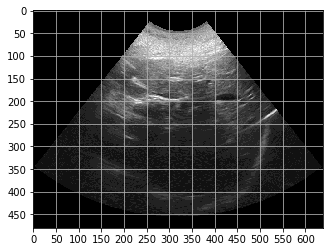

In [231]:
%matplotlib inline
# Visualize images
# Image.open(x)
x = list_imgs[3]
n1, n2 = np.asarray(Image.open(x)).shape
plt.imshow(Image.open(x))
plt.grid(True)
plt.xticks(np.arange(0,n2,step=50))
plt.yticks(np.arange(0,n1,step=50))

In [208]:
# Load labels
df = pd.read_csv(list_features_files[0], header=None, names=['id', 'x', 'y'], sep='\s+')
df.head()
df2 = pd.read_csv(list_features_files[1], header=None, names=['id', 'x', 'y'], sep='\s+')
df2['init'] = np.repeat(df2.x.values[0], len(df2))
df['init']=np.repeat(df.x.values[0], len(df))
print(list_features_files[1])
new = df.append(df2)
print(len(new))
new.head()

/Volumes/BERNHARDT/CLUST_Data/CIL-01/Annotation/CIL-01_2.txt
288


,id,x,y,init
0,1.0,429.86027,199.19809,429.86027
1,17.0,423.04417,198.20180,429.86027
2,21.0,417.55687,196.64463,429.86027
3,32.0,405.53780,197.02837,429.86027
4,40.0,412.64353,195.86047,429.86027


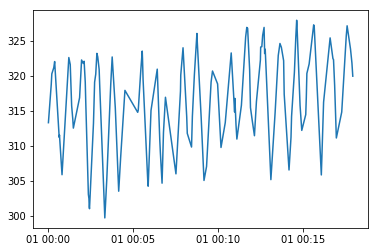

In [48]:
# Visualize time series
from datetime import datetime, timedelta
df.dummy_date = df.id.map(lambda s: datetime.strptime('Jun 1 2005', '%b %d %Y') + timedelta(seconds=s))

plt.plot(df.dummy_date, df.x)

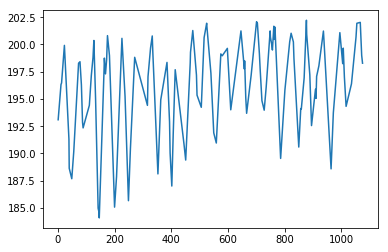

In [37]:
plt.plot(df.id, df.y)

In [62]:
# build ARIMA model
x = df.x.values
time = df.dummy_date.values.dtype

dtype('<M8[ns]')

In [66]:
from sklearn.metrics import mean_squared_error
df.index = df.dummy_date
model = ARIMA(df.x, order=(5,1,0))
model_fit = model.fit(disp=200)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.x   No. Observations:                  130
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -408.820
Method:                       css-mle   S.D. of innovations              5.599
Date:                Tue, 09 Apr 2019   AIC                            831.639
Time:                        12:26:15   BIC                            851.712
Sample:                    06-01-2005   HQIC                           839.796
                         - 06-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0415      0.226      0.184      0.855      -0.402       0.485
ar.L1.D.x     -0.0684      0.087     -0.786      0.433      -0.239       0.102
ar.L2.D.x     -0.4362      0.083     -5.248      0.0

/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Applications/miniconda3/lib/python3.6/s

Test MSE: 28.588


/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


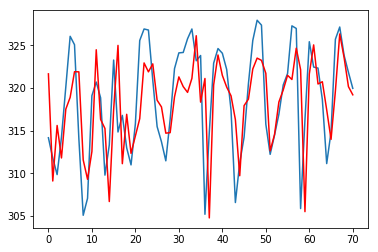

In [104]:
X = df.x.values
size = int(len(X) * 0.66);
size = 60
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')

/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Test MSE: 11.142


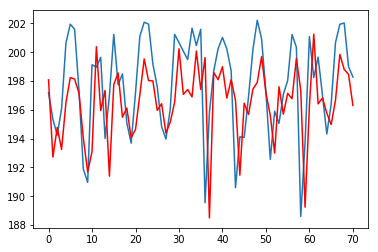

In [105]:
Y = df.y.values
size = int(len(Y) * 0.66)
size = 60
train, test = Y[0:size], Y[size:len(Y)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')

In [153]:
# use a window of 3
x = df.x.values
x_target = x[5:n]
n = len(x)
x_1 = np.append(np.nan, x[0:(n-1)])
x_2 = np.append([np.nan, np.nan], x[0:(n-2)])
x_3 = np.append([np.nan, np.nan, np.nan], x[0:(n-3)])
feats = np.vstack([x,x_1,x_2,x_3])
feats = np.transpose(feats)
feats = feats[4:(n-1)]
feats.shape
print(feats[0:4])
print(x_target[0:4])

[[322.04633 321.18613 320.28973 318.79013]
 [311.23343 322.04633 321.18613 320.28973]
 [311.56087 311.23343 322.04633 321.18613]
 [305.8883  311.56087 311.23343 322.04633]]
[311.23343 311.56087 305.8883  310.71478]


In [209]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
X = new.loc[:,['id', 'init']].values
print(X[1:10])
X_train, X_test, y_train, y_test = train_test_split(X, new.x.values.reshape(-1,1), test_size=0.33, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(feats, x_target, test_size=0.33, random_state=42)
# X_train2, X_test2, y_train2, y_test2 = train_test_split(new.id.values.reshape(-1,1), new.x.values.reshape(-1,1), test_size=0.33, random_state=42)

[[ 17.      429.86027]
 [ 21.      429.86027]
 [ 32.      429.86027]
 [ 40.      429.86027]
 [ 49.      429.86027]
 [ 67.      429.86027]
 [ 69.      429.86027]
 [ 97.      429.86027]
 [106.      429.86027]]


In [211]:
est = RidgeCV()
X.shape
est.fit(X=X_train, y=y_train)
y_pred = est.predict(X_test)
np.mean((y_pred - y_test)**2)

152.55002384260115

/Applications/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


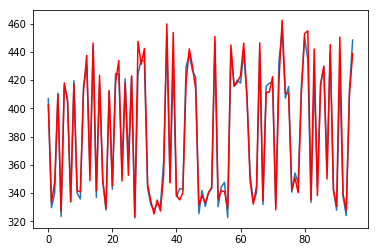

In [214]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
est = GradientBoostingRegressor(n_estimators=1000)
est.fit(X=X_train, y=y_train)
y_pred = est.predict(X_test)
np.mean((y_pred - y_test)**2)
plt.plot(y_pred)
plt.plot(y_test, 'red')

/Applications/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


4242.625473935593


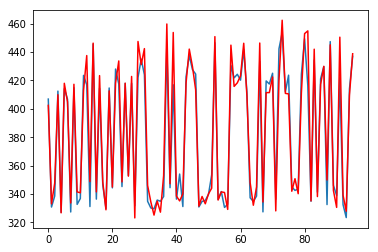

In [215]:
est = RandomForestRegressor(n_estimators=1000)
est.fit(X=X_train, y=y_train)
y_pred = est.predict(X_test)
print(np.mean((y_pred - y_test)**2))
plt.plot(y_pred)
plt.plot(y_test, 'red')

# Part II: building the full dataset. Leave one out subject. 

In [219]:
listdir = [dI for dI in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,dI))]
current_dir = os.path.join(data_dir, listdir[0])
current_annotation_dir = os.path.join(current_dir, 'Annotation')
current_img_dir = os.path.join(current_dir, 'Data')
list_imgs = [os.path.join(current_img_dir, dI) for dI in os.listdir(current_img_dir) if dI.endswith('png')]
list_features_files = [os.path.join(current_annotation_dir, dI) for dI in os.listdir(current_annotation_dir) if dI.endswith('txt')]

k=0
df_test = pd.read_csv(list_features_files[k], header=None, names=['id', 'x', 'y'], sep='\s+')
df_test['init']= np.repeat(df_test.x.values[0], len(df_test))
df_test.head()

df_train = pd.DataFrame(columns = ['id', 'x', 'y', 'init'])
for dir in listdir[1:len(listdir)]:
    current_dir = os.path.join(data_dir, dir)
    current_annotation_dir = os.path.join(current_dir, 'Annotation')
    list_features_files = [os.path.join(current_annotation_dir, dI) for dI \
                           in os.listdir(current_annotation_dir) \
                           if (dI.endswith('txt') and not dI.startswith('.'))]

    for file in list_features_files:
        tmp = pd.read_csv(file, header=None, names=['id', 'x', 'y'], sep='\s+')
        tmp['init'] = np.repeat(tmp.x.values[0], len(tmp))
        df_train = df_train.append(tmp)
        print(len(df_train))

131
394
860
1326
1692
2058
2543
2963
3415
3867
4327
4852
5377
5761
6145
6581
6930
7279
7628
7977
8326
8934
9542
10150
10613
11076
11321
11566
11811
12142
12473
12804


In [220]:
X_train = df_train.loc[:,['id', 'init']].values
y_train = df_train['x'].values
X_test = df_test.loc[:,['id', 'init']].values
y_test = df_test.loc[:,'x'].values

In [221]:
est = RidgeCV()
X.shape
est.fit(X=X_train, y=y_train)
y_pred = est.predict(X_test)
np.mean((y_pred - y_test)**2)

428.02573362948544

4343.808157426995


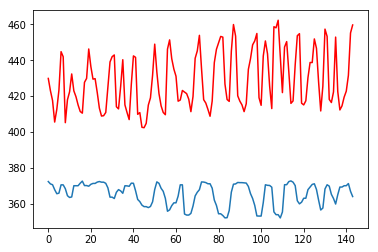

In [222]:
est = RandomForestRegressor(n_estimators=1000)
est.fit(X=X_train, y=y_train)
y_pred = est.predict(X_test)
print(np.mean((y_pred - y_test)**2))
plt.plot(y_pred)
plt.plot(y_test, 'red')

# Part III: dealing with the images

In [301]:
## First trial https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5688953/
img1 = list_imgs[0]
img2 = list_imgs[1]
file1 = list_features_files[0]
df = pd.read_csv(list_features_files[0], header=None, names=['id', 'x', 'y'], sep='\s+')
df.head()

# Implement global matching search via NCC
    # 1. Define template of size [50,50] or less it depends
    # 2. Extract template of previous frame. 
    # 3. Calculate the search points. grid of 51x51 pixel around the previous center point.
    # 4. Look for the highest NCC, if NNC is above 0.55 accept this template.
    # 5. Else recalculate with good previous frame, if NCC above 0.55 accept this one.
    # 6. Else recalculate with init frame, if NCC above 0.55 accept.
    # 7.  if all three global searches have a maximum of less than the threshold, 
    # the maximum across all three is used to define the global shift. 
# Returns the template containing the features.
# Assess this part separately. 

# Implement local search. 
    # Random forest with intensity distribution of previous template (if good), of init frame/good previous template,
    # with previous position location or even ten last positions. 
    # Try to compare with their method.

,id,x,y
0,1.0,429.86027,199.19809
1,17.0,423.04417,198.20180
2,21.0,417.55687,196.64463
3,32.0,405.53780,197.02837
4,40.0,412.64353,195.86047


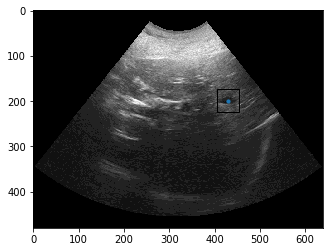

/Volumes/BERNHARDT/CLUST_Data/CIL-01/Data/0001.png


In [271]:
from matplotlib.patches import Rectangle
c1, c2 = df.loc[0, ['x', 'y']]
width = 50
height = 50
x = c1 - width/2
y = c2 - height/2
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(Image.open(img1))
ax.scatter(c1, c2, s=10)
rect=Rectangle((x,y), width, height, fill=False)
ax.add_patch(rect)
plt.show()
print(img1)

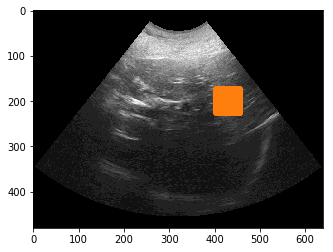

In [314]:
# Find pixels around a given center
def find_pixel_circle(c1, c2):
    xax = np.arange(int(c1)-25, int(c1)+26, step=1)
    yax = np.arange(int(c2)-25, int(c2)+26, step=1)
    return np.meshgrid(xax, yax) # all the x,y in the template centered around c1, c2
xv, yv = find_pixel_circle(c1, c2)  
im1 = np.asarray(Image.open(img1))
im2 = np.asarray(Image.open(img2))
# Display the image
# Create figure and axes
fig,ax = plt.subplots(1)
ax.imshow(Image.open(img1))
ax.scatter(c1, c2, s=1)
ax.scatter(xv, yv)
plt.show()

In [329]:
m_previous = np.mean(im1[xv, yv])
xv, yv = find_pixel_circle(c1, c2) 
NCC_all = []
for i,j in zip(np.ravel(xv), np.ravel(yv)):
    tmp_x, tmp_y = find_pixel_circle(i, j)
    x1 = np.ravel(im1[xv, yv])
    x2 = np.ravel(im2[tmp_x, tmp_y])
    x1 = x1 - np.mean(x1)
    x2 = x2 - np.mean(x2)
    num = np.sum(x1*x2)
    denom = np.sqrt(np.sum(x1**2)*np.sum(x2**2))
    NCC_all.append(num/denom)
print(np.max(NCC_all))
print(np.argmax(NCC_all)) # TO CHECK how to get back to the coordinates?


0.8264041093886912
1300


In [ ]:
## 
# Build a "feature detection" network
# feed the initial box, the current frame as an input and try to predict the center of the object. 

# could also divide in a grid and compute the correlation of each box with the initial box containing the center. 


# could also do the predictions in a row and limit to a big box around the previous prediction or around the 
# predicted value from the time series.

# or just feed location 1, image 1, image 2 and predict location 1 in image 2. 
